In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import accuracy,Dataset, Reader, NMF, SVD
from surprise.model_selection import cross_validate, KFold
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from collections import Counter
import lightgbm as lgb

Question 1

In [2]:
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()
num_ratings = len(ratings)

sparsity = num_ratings / (num_users * num_movies)
print(f"Sparsity of the dataset: {sparsity}")

Sparsity of the dataset: 0.016999683055613623


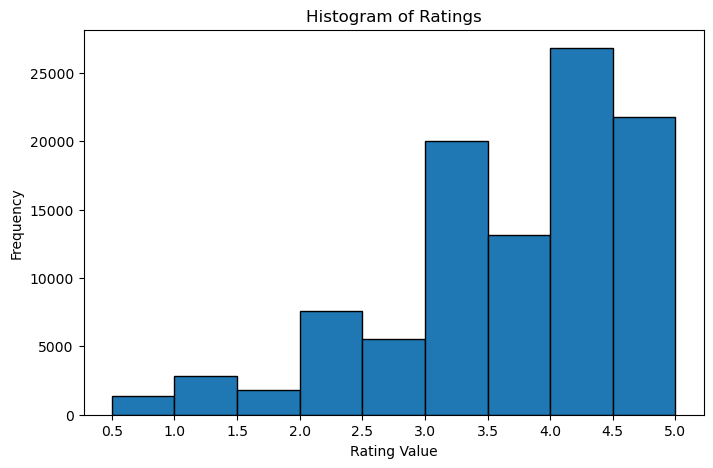

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(ratings["rating"], bins=np.arange(0.5, 5.5, 0.5), edgecolor='black')
plt.xlabel("Rating Value")
plt.ylabel("Frequency")
plt.title("Histogram of Ratings")
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.show()

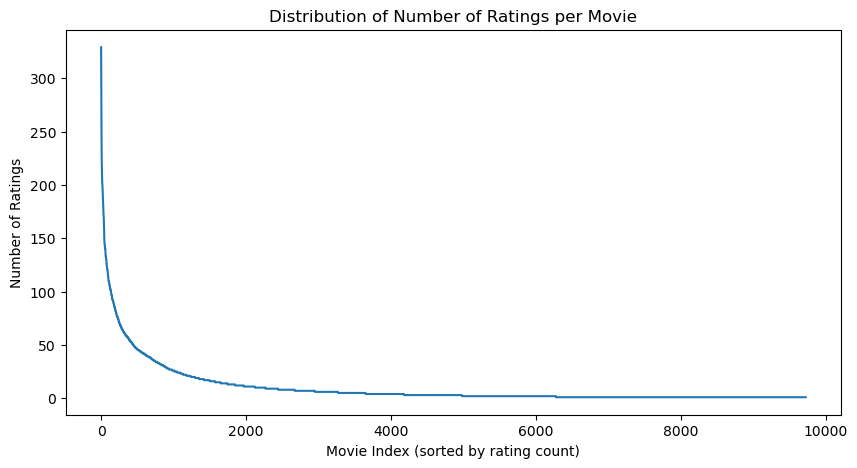

In [6]:
movie_counts = ratings["movieId"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.plot(movie_counts.values)
plt.xlabel("Movie Index")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Number of Ratings per Movie")
plt.show()

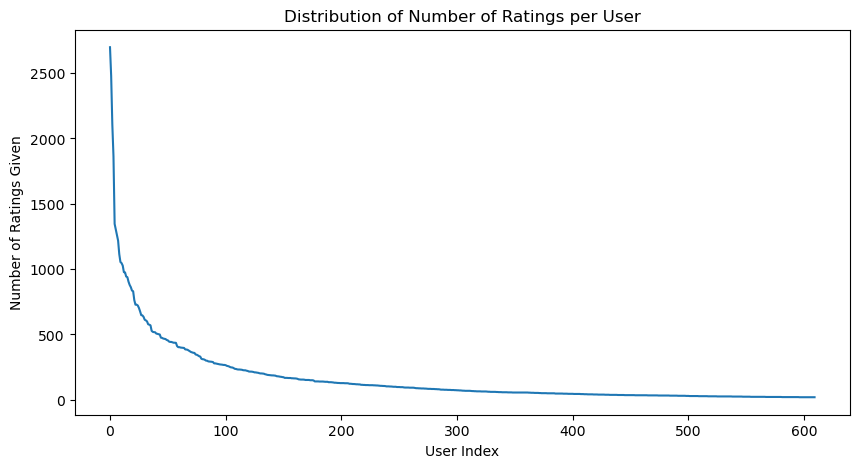

In [8]:
user_counts = ratings["userId"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.plot(user_counts.values)
plt.xlabel("User Index")
plt.ylabel("Number of Ratings Given")
plt.title("Distribution of Number of Ratings per User")
plt.show()

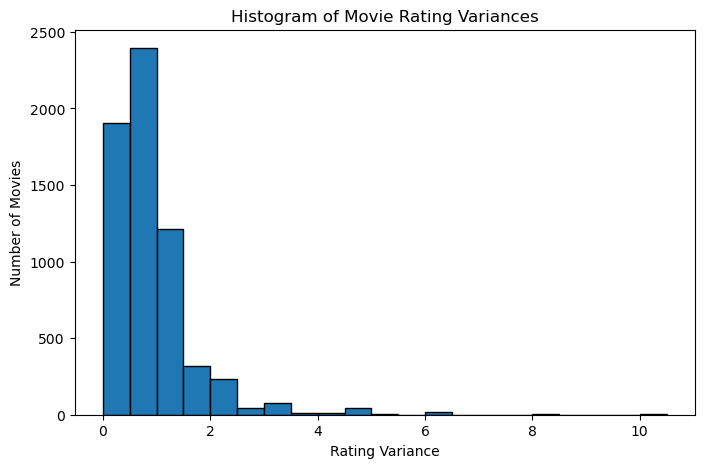

In [11]:
movie_variances = ratings.groupby("movieId")["rating"].var()
movie_variances = movie_variances.dropna()

plt.figure(figsize=(8, 5))
plt.hist(movie_variances, bins=np.arange(0, max(movie_variances) + 0.5, 0.5), edgecolor='black')
plt.xlabel("Rating Variance")
plt.ylabel("Number of Movies")
plt.title("Histogram of Movie Rating Variances")
plt.show()

Question 4

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

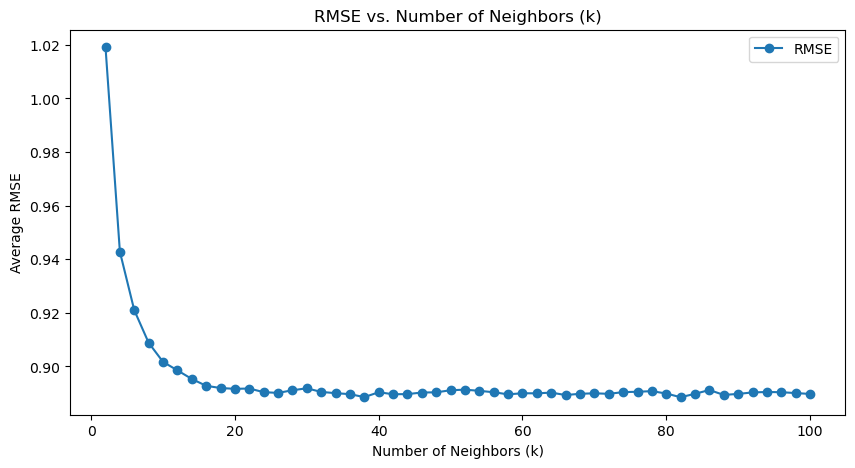

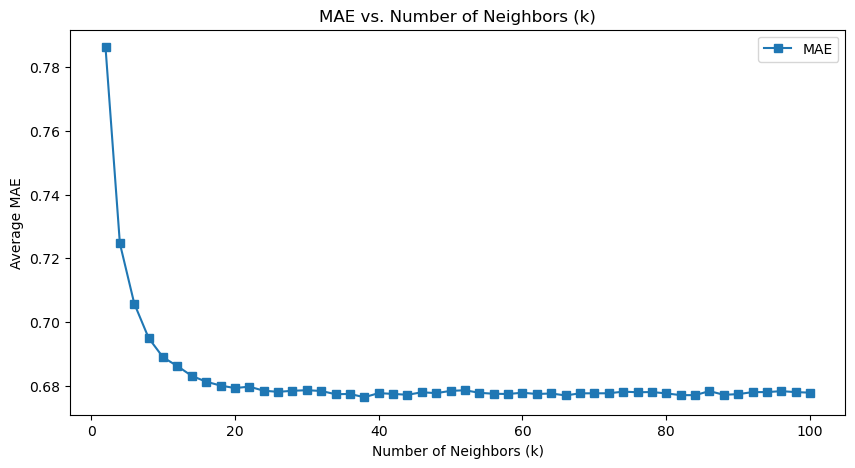

In [17]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)

rmse_values = []
mae_values = []
k_values = list(range(2, 102, 2))

for k in k_values:
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=False)

    avg_rmse = np.mean(cv_results['test_rmse'])
    avg_mae = np.mean(cv_results['test_mae'])

    rmse_values.append(avg_rmse)
    mae_values.append(avg_mae)

plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', label='RMSE')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_values, marker='s', linestyle='-', label='MAE')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average MAE")
plt.title("MAE vs. Number of Neighbors (k)")
plt.legend()
plt.show()

Question 5

In [18]:
index_k_20 = k_values.index(20)

rmse_k_20 = rmse_values[index_k_20]
mae_k_20 = mae_values[index_k_20]

print(f"Average RMSE for k=20: {rmse_k_20:.4f}")
print(f"Average MAE for k=20: {mae_k_20:.4f}")


Average RMSE for k=20: 0.8917
Average MAE for k=20: 0.6793


Question 6

In [3]:
def trim_popular_movies(ratings_df):
    movie_counts = ratings_df["movieId"].value_counts()
    popular_movies = movie_counts[movie_counts > 2].index
    return ratings_df[ratings_df["movieId"].isin(popular_movies)]

def trim_unpopular_movies(ratings_df):
    movie_counts = ratings_df["movieId"].value_counts()
    unpopular_movies = movie_counts[movie_counts <= 2].index
    return ratings_df[ratings_df["movieId"].isin(unpopular_movies)]

def trim_high_variance_movies(ratings_df):
    movie_variances = ratings_df.groupby("movieId")["rating"].var()
    movie_counts = ratings_df["movieId"].value_counts()
    high_variance_movies = movie_variances[(movie_variances >= 2) & (movie_counts >= 5)].index
    return ratings_df[ratings_df["movieId"].isin(high_variance_movies)]


In [23]:
def evaluate_knn_collaborative_filter(ratings_df, k_values):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

    kf = KFold(n_splits=10)
    rmse_values = []

    for k in k_values:
        algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
        rmse_scores = []

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)

            rmse = accuracy.rmse(predictions, verbose=False)
            rmse_scores.append(rmse)

        avg_rmse = np.mean(rmse_scores)
        rmse_values.append(avg_rmse)

    return rmse_values

k_values = list(range(2, 102, 2))

rmse_popular = evaluate_knn_collaborative_filter(trim_popular_movies(ratings), k_values)
rmse_unpopular = evaluate_knn_collaborative_filter(trim_unpopular_movies(ratings), k_values)
rmse_high_var = evaluate_knn_collaborative_filter(trim_high_variance_movies(ratings), k_values)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

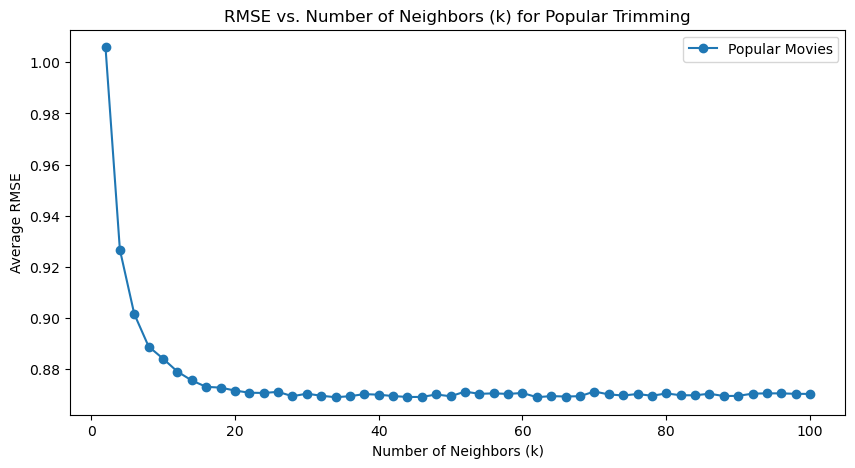

Minimum RMSE for Popular Movies: 0.8690


In [29]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_popular, marker='o', label="Popular Movies")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k) for Popular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Popular Movies: {min(rmse_popular):.4f}")


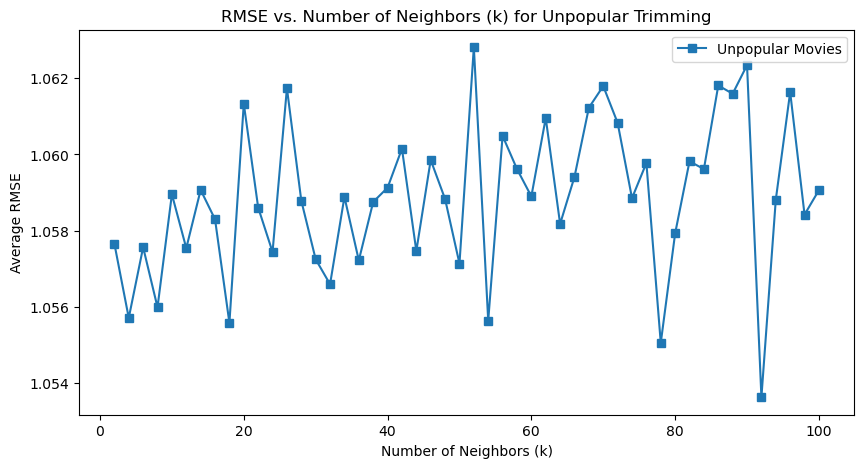

Minimum RMSE for Unpopular Movies: 1.0536


In [30]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_unpopular, marker='s', label="Unpopular Movies")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k) for Unpopular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Unpopular Movies: {min(rmse_unpopular):.4f}")

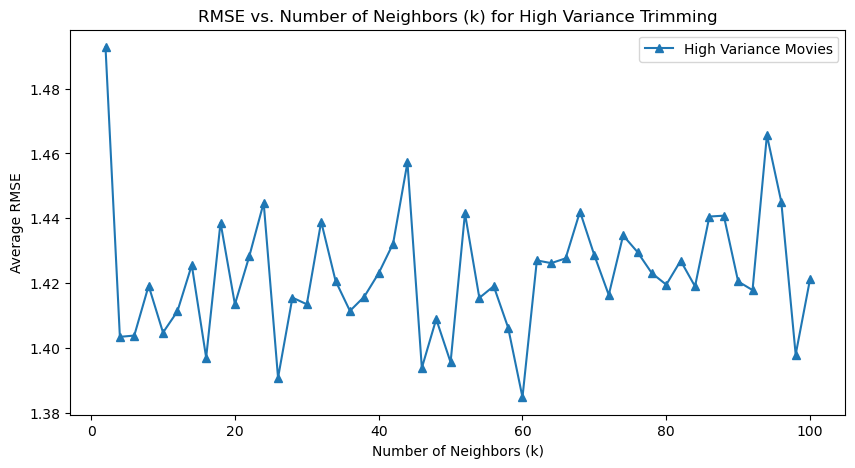

Minimum RMSE for High Variance Movies: 1.3847


In [31]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_high_var, marker='^', label="High Variance Movies")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k) for High Variance Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for High Variance Movies: {min(rmse_high_var):.4f}")

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


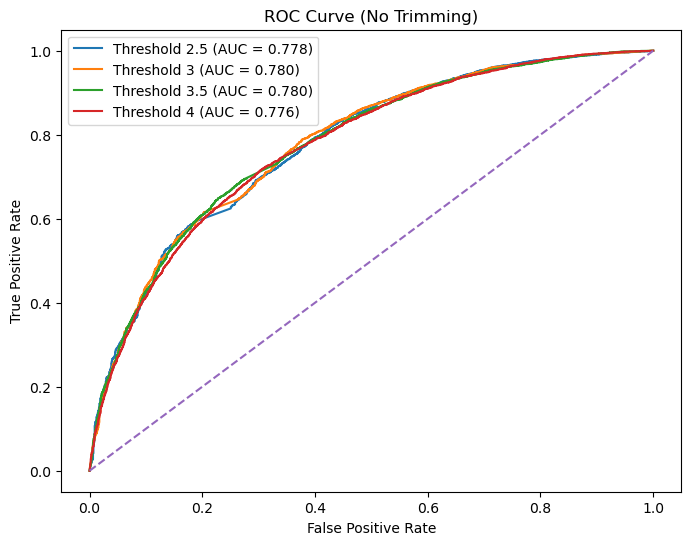

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


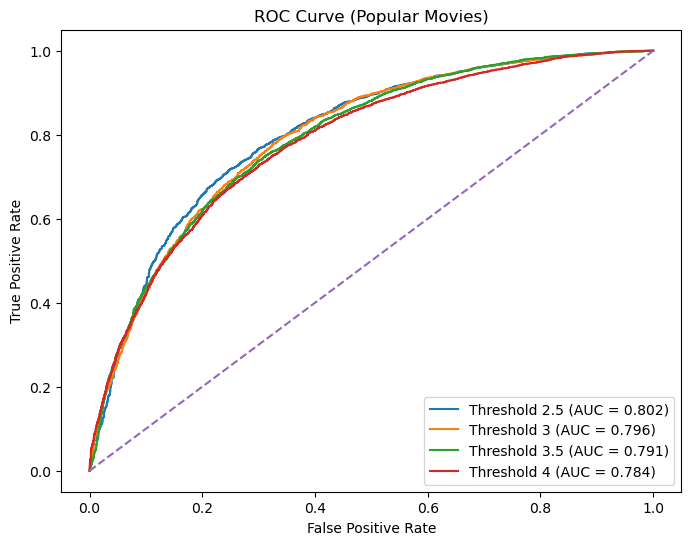

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


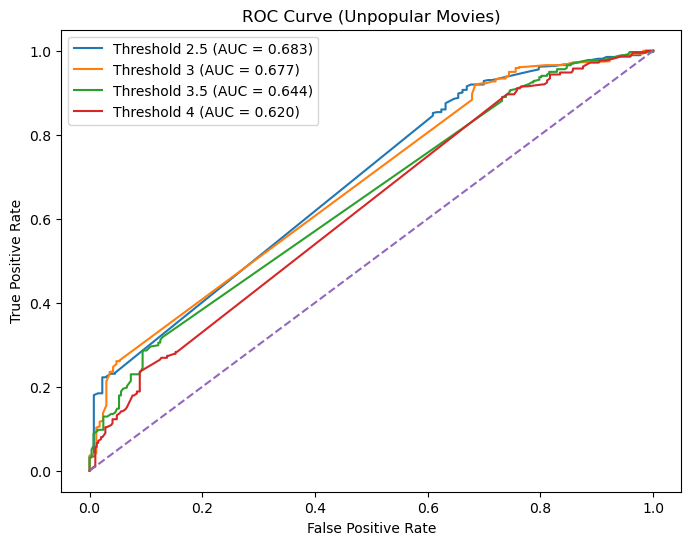

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


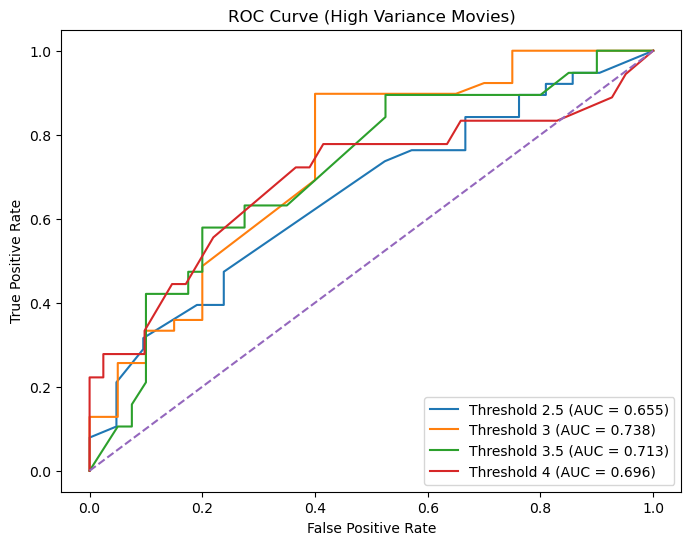

In [34]:
def compute_roc_curve(ratings_df, threshold):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    
    trainset, testset = train_test_split(data, test_size=0.1)

    algo = KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True})
    algo.fit(trainset)
    predictions = algo.test(testset)

    true_labels = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    predicted_scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score

thresholds = [2.5, 3, 3.5, 4]

trimming_options = {
    "No Trimming": ratings,
    "Popular Movies": trim_popular_movies(ratings),
    "Unpopular Movies": trim_unpopular_movies(ratings),
    "High Variance Movies": trim_high_variance_movies(ratings)
}

for trim_name, trimmed_data in trimming_options.items():
    plt.figure(figsize=(8, 6))

    for threshold in thresholds:
        fpr, tpr, auc_score = compute_roc_curve(trimmed_data, threshold)
        plt.plot(fpr, tpr, label=f"Threshold {threshold} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({trim_name})")
    plt.legend()
    
    plt.show()



Question 8

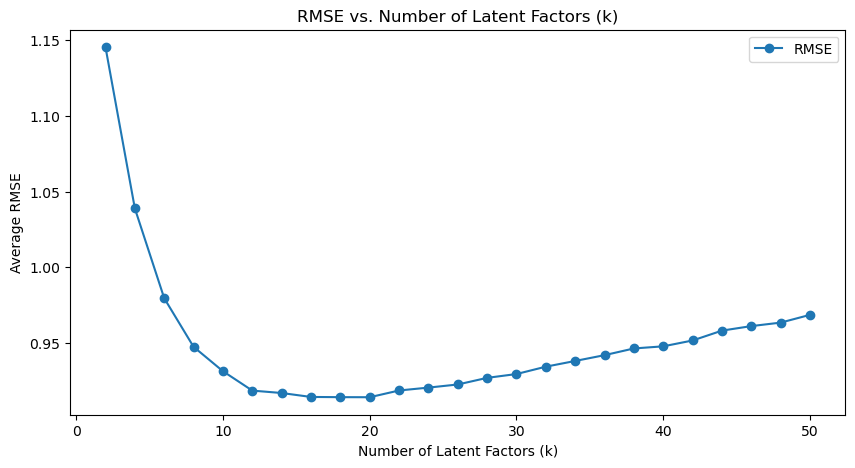

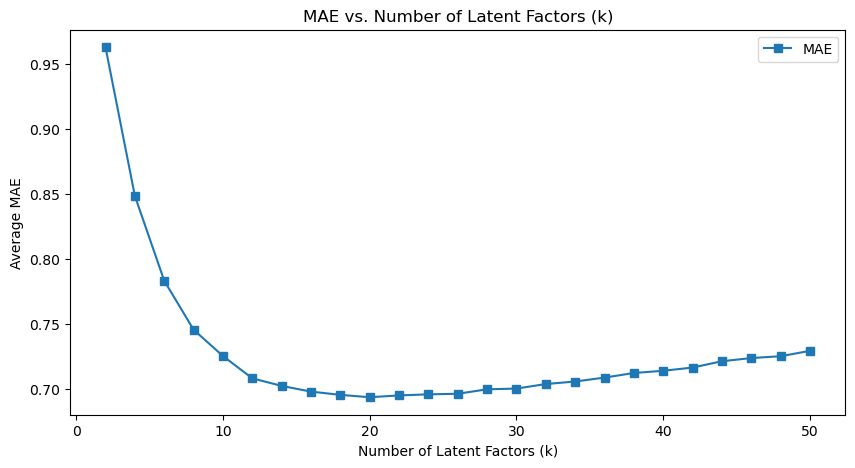

In [38]:
ratings = pd.read_csv("ratings.csv")
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
k_values = list(range(2, 52, 2))
rmse_values = []
mae_values = []

for k in k_values:
    algo = NMF(n_factors=k)
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    rmse_values.append(np.mean(cv_results['test_rmse']))
    mae_values.append(np.mean(cv_results['test_mae']))

plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_values, marker='o', label="RMSE")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_values, marker='s', label="MAE")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average MAE")
plt.title("MAE vs. Number of Latent Factors (k)")
plt.legend()
plt.show()

In [41]:
optimal_k_rmse = k_values[np.argmin(rmse_values)]
optimal_k_mae = k_values[np.argmin(mae_values)]

min_rmse = rmse_values[np.argmin(rmse_values)]
min_mae = mae_values[np.argmin(mae_values)]

print(f"Optimal number of latent factors (k) based on RMSE: {optimal_k_rmse}")
print(f"Minimum average RMSE: {min_rmse:.4f}")

print(f"Optimal number of latent factors (k) based on MAE: {optimal_k_mae}")
print(f"Minimum average MAE: {min_mae:.4f}")

num_movie_genres = 18

if optimal_k_rmse == num_movie_genres:
    print("The optimal number of latent factors matches the number of movie genres.")
else:
    print("The optimal number of latent factors does NOT match the number of movie genres.")

if optimal_k_mae == num_movie_genres:
    print("The optimal number of latent factors matches the number of movie genres.")
else:
    print("The optimal number of latent factors does NOT match the number of movie genres.")

Optimal number of latent factors (k) based on RMSE: 20
Minimum average RMSE: 0.9141
Optimal number of latent factors (k) based on MAE: 20
Minimum average MAE: 0.6938
The optimal number of latent factors does NOT match the number of movie genres.
The optimal number of latent factors does NOT match the number of movie genres.


In [ ]:
def evaluate_nmf_collaborative_filter(ratings_df, k_values):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

    kf = KFold(n_splits=10)
    rmse_values = []

    for k in k_values:
        algo = NMF(n_factors=k)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=False)
        rmse_values.append(np.mean(cv_results['test_rmse']))

    return rmse_values

rmse_popular = evaluate_nmf_collaborative_filter(trim_popular_movies(ratings), k_values)
rmse_unpopular = evaluate_nmf_collaborative_filter(trim_unpopular_movies(ratings), k_values)
rmse_high_var = evaluate_nmf_collaborative_filter(trim_high_variance_movies(ratings), k_values)

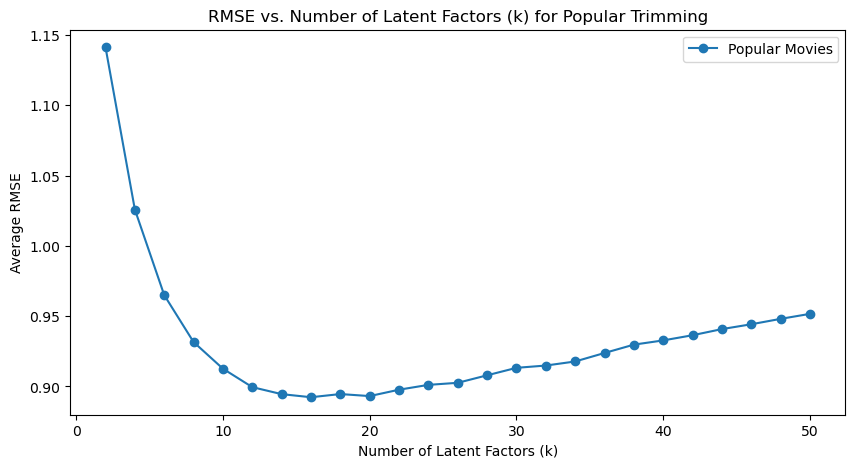

Minimum RMSE for Popular Movies: 0.8923


In [43]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_popular, marker='o', label="Popular Movies")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k) for Popular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Popular Movies: {min(rmse_popular):.4f}")

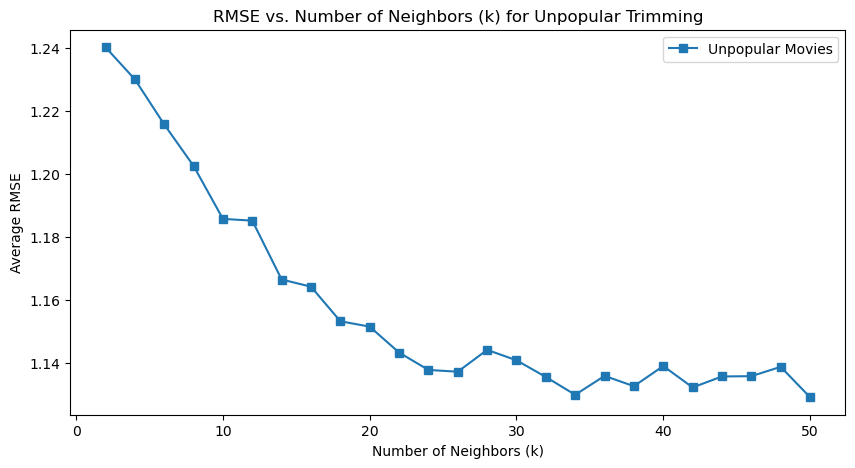

Minimum RMSE for Unpopular Movies: 1.1291


In [44]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_unpopular, marker='s', label="Unpopular Movies")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k) for Unpopular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Unpopular Movies: {min(rmse_unpopular):.4f}")

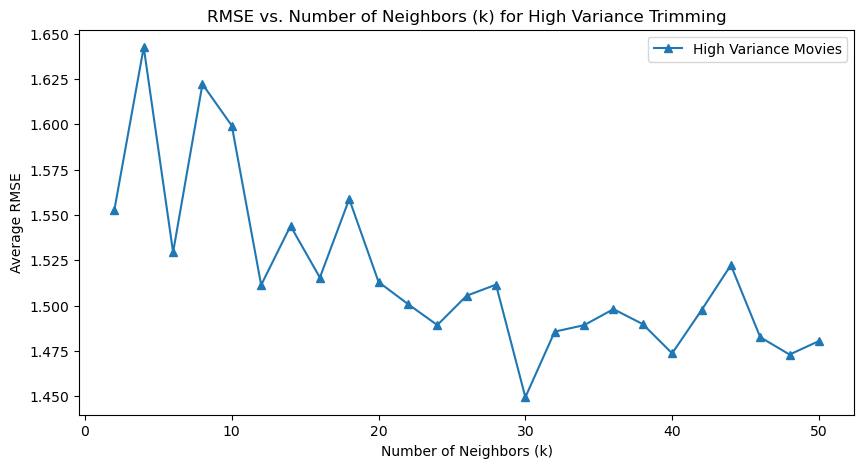

Minimum RMSE for High Variance Movies: 1.4494


In [45]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_high_var, marker='^', label="High Variance Movies")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Neighbors (k) for High Variance Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for High Variance Movies: {min(rmse_high_var):.4f}")

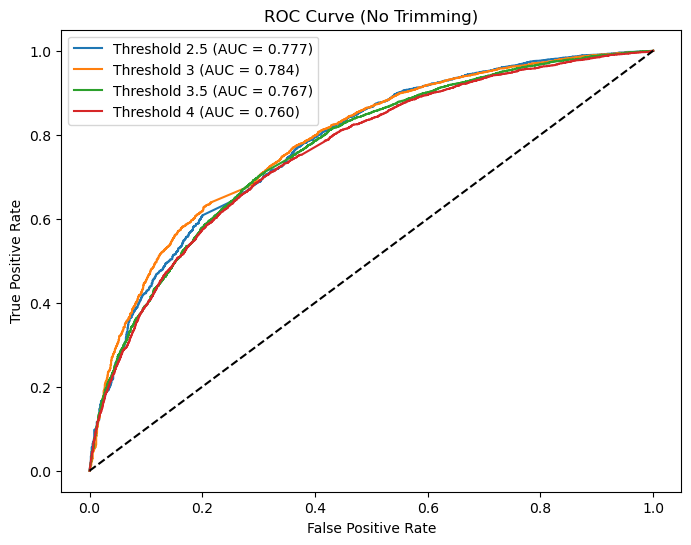

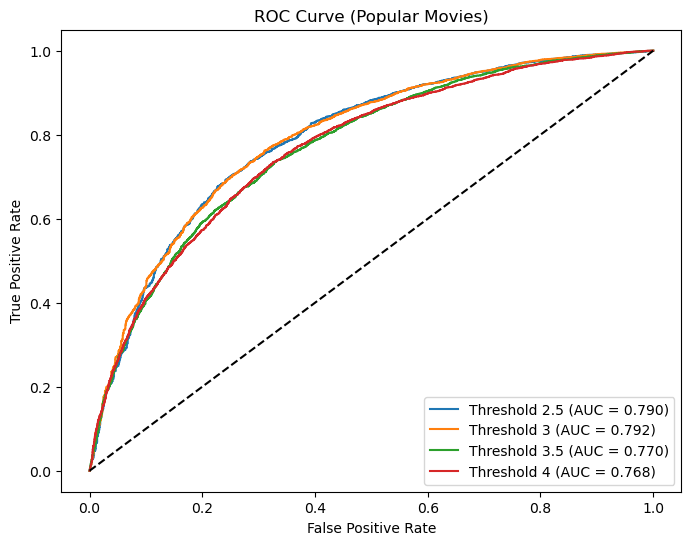

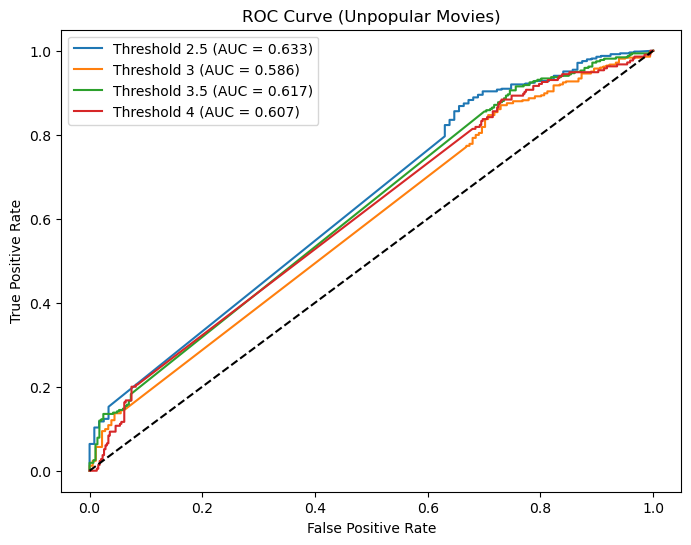

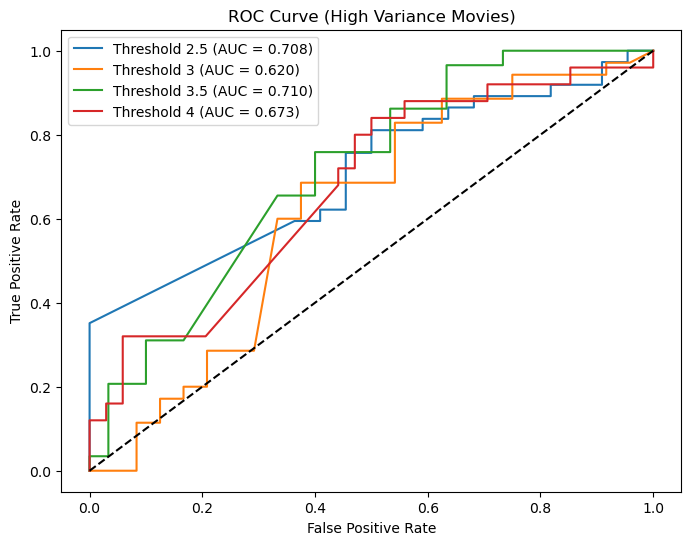

In [46]:
def compute_roc_curve_nmf(ratings_df, threshold):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    
    trainset, testset = train_test_split(data, test_size=0.1)

    algo = NMF(n_factors=optimal_k_rmse)
    algo.fit(trainset)
    predictions = algo.test(testset)

    true_labels = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    predicted_scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score

for trim_name, trimmed_data in trimming_options.items():
    plt.figure(figsize=(8, 6))
    
    for threshold in thresholds:
        fpr, tpr, auc_score = compute_roc_curve_nmf(trimmed_data, threshold)
        plt.plot(fpr, tpr, label=f"Threshold {threshold} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({trim_name})")
    plt.legend()
    
    plt.show()

Question 9

In [52]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
nmf = NMF(n_factors=20).fit(train)
nmf.test(test)

U_M = nmf.pu
V_M = nmf.qi
movie_latent_df = pd.DataFrame(V_M)

for col in movie_latent_df:
    top_10_movies = movies.iloc[movie_latent_df[col].nlargest(10).index]

    top_10_movie_genres = top_10_movies['genres'].tolist()
    unique_genres = set('|'.join(top_10_movie_genres).split('|'))

    print(f'For latent factor {col}, the genres of the top 10 movies are:')
    print(top_10_movie_genres)
    print(f'The top 10 movies belong to these genres: {unique_genres}')
    print(f'There are {len(unique_genres)} unique genres.')
    print('\n')


For latent factor 0, the genres of the top 10 movies are:
['Horror', 'Children|Comedy', 'Action|Comedy|Crime|Drama', 'Animation|Children|Comedy|Fantasy|Musical', 'Comedy', 'Comedy', 'Comedy|Sci-Fi', 'Comedy|War|Western', 'Documentary', 'Comedy|Drama']
The top 10 movies belong to these genres: {'Comedy', 'Drama', 'Animation', 'Western', 'Horror', 'Action', 'Crime', 'Children', 'War', 'Musical', 'Documentary', 'Sci-Fi', 'Fantasy'}
There are 13 unique genres.


For latent factor 1, the genres of the top 10 movies are:
['Children|Comedy|Romance', 'Drama', 'Drama', 'Adventure|Thriller|Western', 'Horror', 'Action|Adventure', 'Adventure|Animation|Children|Comedy', 'Adventure|Drama|Western', 'Adventure|Comedy|Musical', 'Drama|Musical|Romance']
The top 10 movies belong to these genres: {'Comedy', 'Drama', 'Western', 'Animation', 'Horror', 'Action', 'Thriller', 'Romance', 'Children', 'Musical', 'Adventure'}
There are 11 unique genres.


For latent factor 2, the genres of the top 10 movies are:
[

Question 10

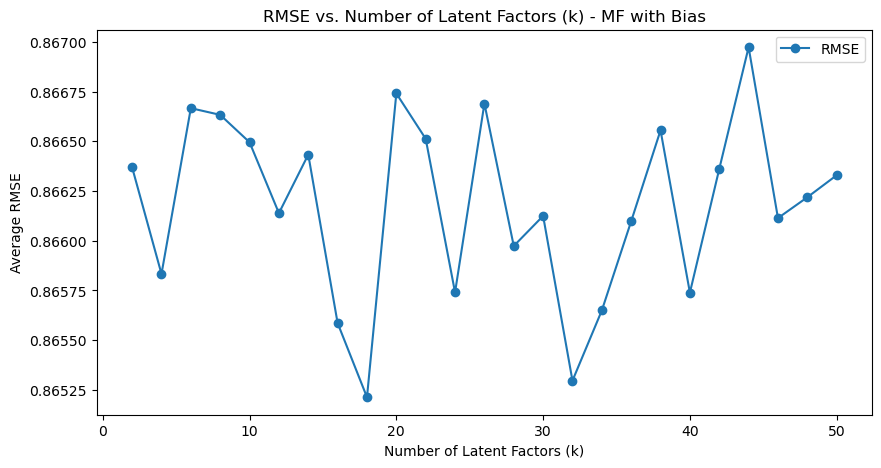

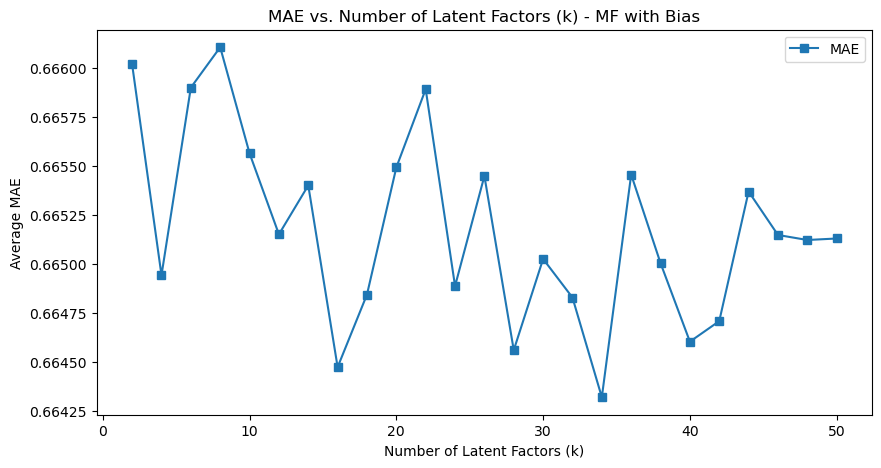

In [54]:
ratings = pd.read_csv("ratings.csv")
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
k_values = list(range(2, 52, 2))
rmse_values = []
mae_values = []

for k in k_values:
    algo = SVD(n_factors=k, biased=True)
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    rmse_values.append(np.mean(cv_results['test_rmse']))
    mae_values.append(np.mean(cv_results['test_mae']))

plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_values, marker='o', label="RMSE")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k) - MF with Bias")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_values, marker='s', label="MAE")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average MAE")
plt.title("MAE vs. Number of Latent Factors (k) - MF with Bias")
plt.legend()
plt.show()


In [55]:
optimal_k_rmse = k_values[np.argmin(rmse_values)]
optimal_k_mae = k_values[np.argmin(mae_values)]

min_rmse = rmse_values[np.argmin(rmse_values)]
min_mae = mae_values[np.argmin(mae_values)]

print(f"Optimal number of latent factors (k) based on RMSE: {optimal_k_rmse}")
print(f"Minimum average RMSE: {min_rmse:.4f}")

print(f"Optimal number of latent factors (k) based on MAE: {optimal_k_mae}")
print(f"Minimum average MAE: {min_mae:.4f}")

num_movie_genres = 18

if optimal_k_rmse == num_movie_genres:
    print("The optimal number of latent factors matches the number of movie genres.")
else:
    print("The optimal number of latent factors does NOT match the number of movie genres.")

if optimal_k_mae == num_movie_genres:
    print("The optimal number of latent factors matches the number of movie genres.")
else:
    print("The optimal number of latent factors does NOT match the number of movie genres.")

Optimal number of latent factors (k) based on RMSE: 18
Minimum average RMSE: 0.8652
Optimal number of latent factors (k) based on MAE: 34
Minimum average MAE: 0.6643
The optimal number of latent factors matches the number of movie genres.
The optimal number of latent factors does NOT match the number of movie genres.


In [56]:
def evaluate_mf_bias_collaborative_filter(ratings_df, k_values):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

    kf = KFold(n_splits=10)
    rmse_values = []

    for k in k_values:
        algo = SVD(n_factors=k, biased=True)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=False)
        rmse_values.append(np.mean(cv_results['test_rmse']))

    return rmse_values

rmse_popular = evaluate_mf_bias_collaborative_filter(trim_popular_movies(ratings), k_values)
rmse_unpopular = evaluate_mf_bias_collaborative_filter(trim_unpopular_movies(ratings), k_values)
rmse_high_var = evaluate_mf_bias_collaborative_filter(trim_high_variance_movies(ratings), k_values)

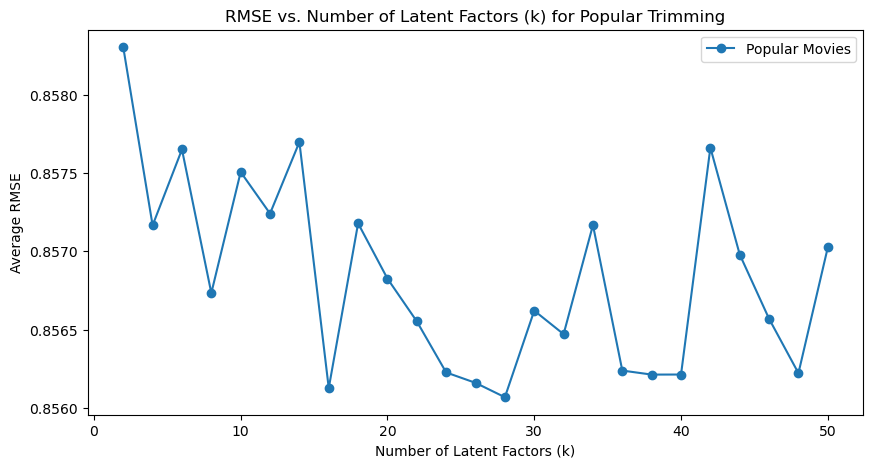

Minimum RMSE for Popular Movies: 0.8561


In [57]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_popular, marker='o', label="Popular Movies")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k) for Popular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Popular Movies: {min(rmse_popular):.4f}")

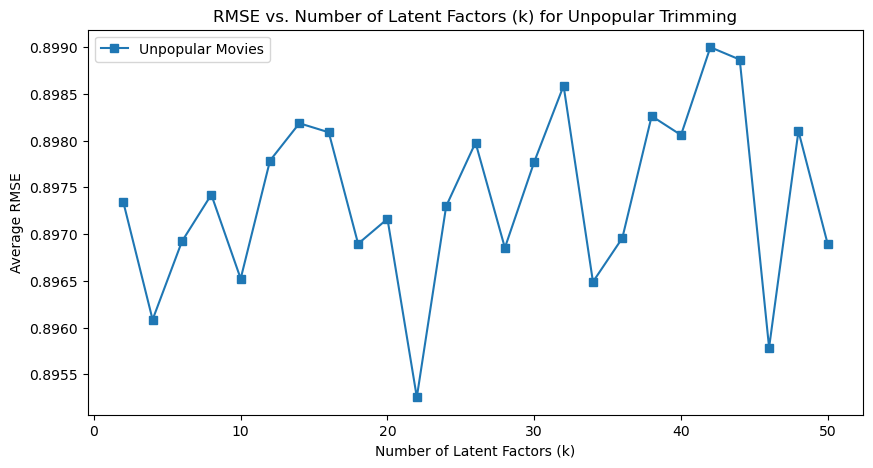

Minimum RMSE for Unpopular Movies: 0.8953


In [58]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_unpopular, marker='s', label="Unpopular Movies")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k) for Unpopular Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for Unpopular Movies: {min(rmse_unpopular):.4f}")

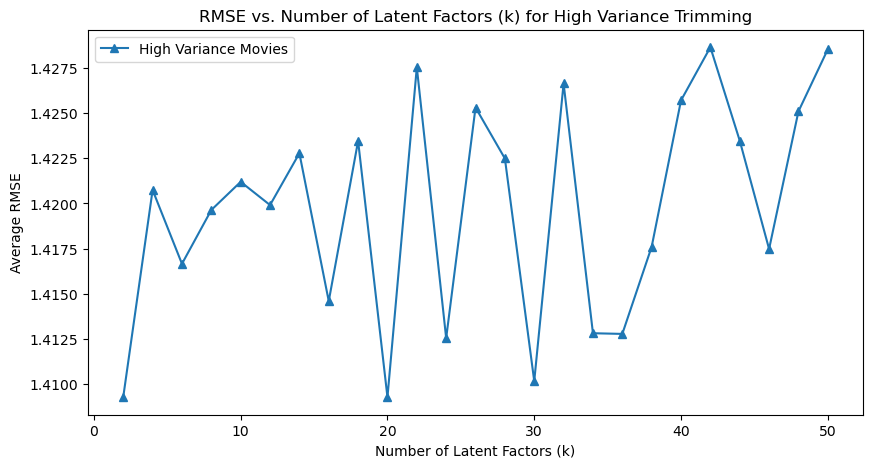

Minimum RMSE for High Variance Movies: 1.4093


In [59]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_high_var, marker='^', label="High Variance Movies")
plt.xlabel("Number of Latent Factors (k)")
plt.ylabel("Average RMSE")
plt.title("RMSE vs. Number of Latent Factors (k) for High Variance Trimming")
plt.legend()
plt.show()

print(f"Minimum RMSE for High Variance Movies: {min(rmse_high_var):.4f}")

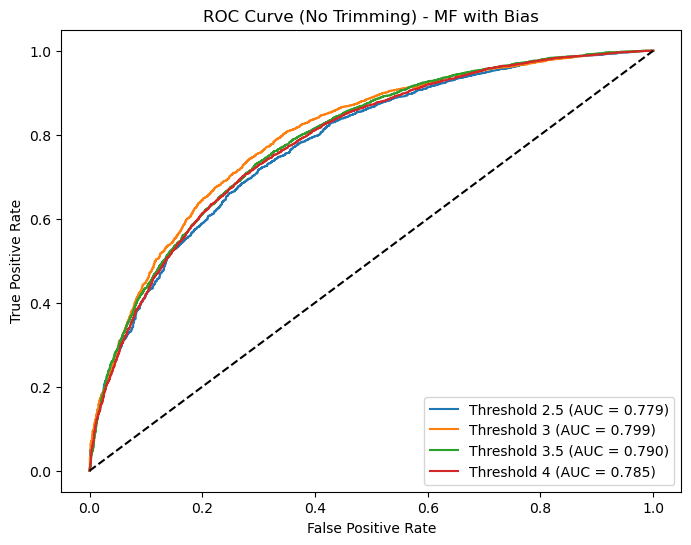

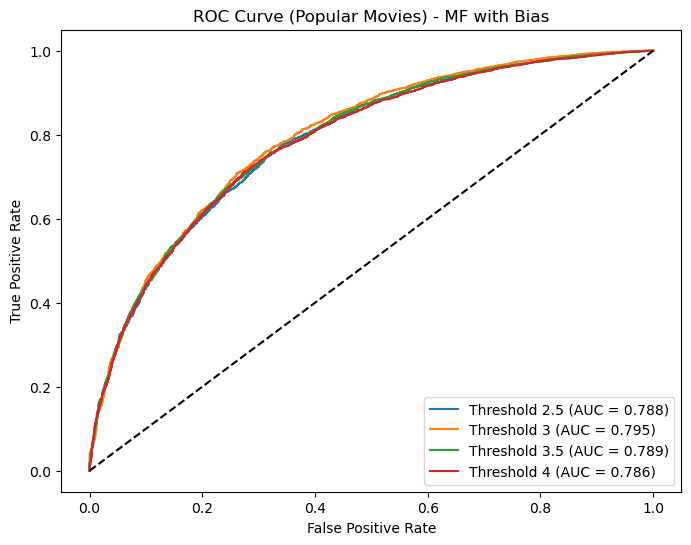

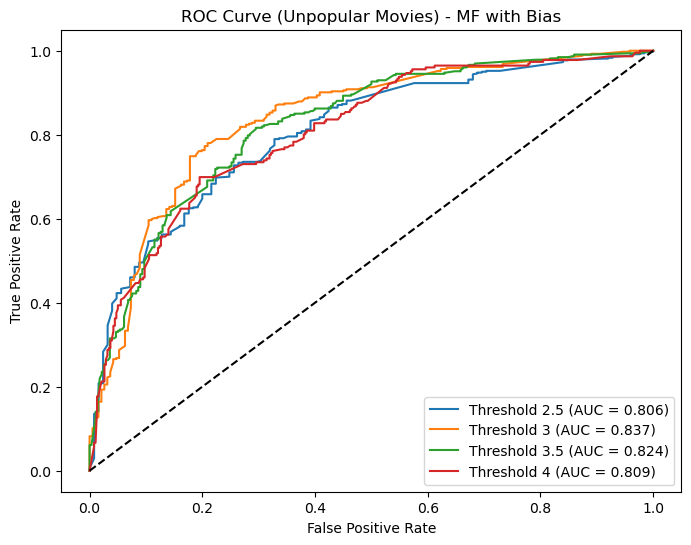

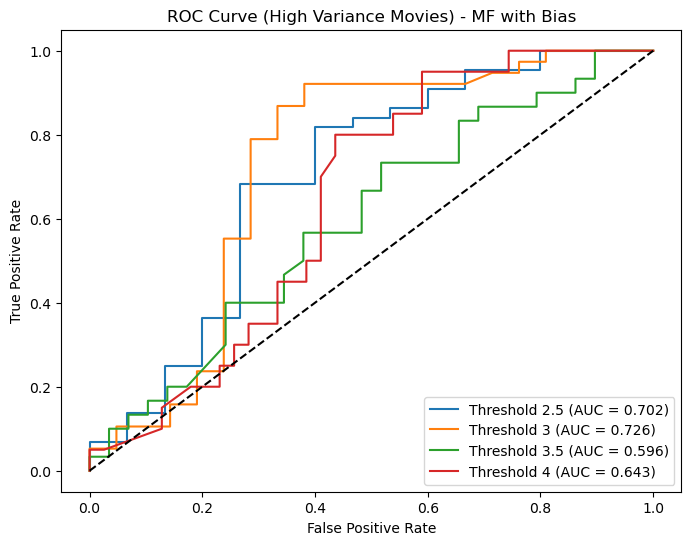

In [60]:
def compute_roc_curve_mf_bias(ratings_df, threshold):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    
    trainset, testset = train_test_split(data, test_size=0.1)

    algo = SVD(n_factors=optimal_k_rmse, biased=True)
    algo.fit(trainset)
    predictions = algo.test(testset)

    true_labels = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    predicted_scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score


for trim_name, trimmed_data in trimming_options.items():
    plt.figure(figsize=(8, 6))
    
    for threshold in thresholds:
        fpr, tpr, auc_score = compute_roc_curve_mf_bias(trimmed_data, threshold)
        plt.plot(fpr, tpr, label=f"Threshold {threshold} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({trim_name}) - MF with Bias")
    plt.legend()
    
    plt.show()

Question 11

In [17]:
ratings = pd.read_csv("ratings.csv")
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)

def naive_collab_filter(trainset, testset):
    user_means = {uid: np.mean([r for (_, r) in trainset.ur[uid]]) for uid in trainset.ur}
    global_mean = trainset.global_mean

    predictions = [user_means.get(uid, global_mean) for uid, _, _ in testset]
    actual_ratings = [actual for _, _, actual in testset]

    return np.sqrt(mean_squared_error(actual_ratings, predictions))

rmse_scores = []

for trainset, testset in kf.split(data):
    rmse = naive_collab_filter(trainset, testset)
    rmse_scores.append(rmse)

average_rmse = np.mean(rmse_scores)
print(f"Naïve Collaborative Filter for No Trimming: {average_rmse:.4f}")

Naïve Collaborative Filter for No Trimming: 1.1412


In [19]:
def evaluate_naive_trimmed(ratings_subset):
    trimmed_data = Dataset.load_from_df(ratings_subset[['userId', 'movieId', 'rating']], reader)
    rmse_scores = []

    for trainset, testset in kf.split(trimmed_data):
        rmse = naive_collab_filter(trainset, testset)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

rmse_popular = evaluate_naive_trimmed(trim_popular_movies(ratings))
rmse_unpopular = evaluate_naive_trimmed(trim_unpopular_movies(ratings))
rmse_high_var = evaluate_naive_trimmed(trim_high_variance_movies(ratings))

print(f"Naïve Collaborative Filter for Popular Movies: {rmse_popular:.4f}")
print(f"Naïve Collaborative Filter for Unpopular Movies: {rmse_unpopular:.4f}")
print(f"Naïve Collaborative Filter for High-Variance Movies: {rmse_high_var:.4f}")

Naïve Collaborative Filter for Popular Movies: 1.1466
Naïve Collaborative Filter for Unpopular Movies: 1.3054
Naïve Collaborative Filter for High-Variance Movies: 1.5958


Question 12

Computing the pearson similarity matrix...
Done computing similarity matrix.


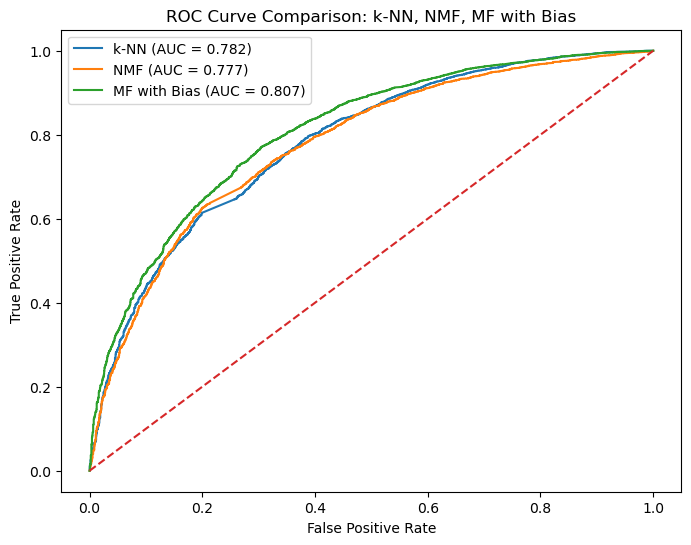

In [21]:
def compute_roc_curve(algo, data, threshold=3):
    trainset, testset = train_test_split(data, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)

    true_labels = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    predicted_scores = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
    auc_score = auc(fpr, tpr)

    return fpr, tpr, auc_score

models = {
    "k-NN": KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True}),
    "NMF": NMF(n_factors=20),
    "MF with Bias": SVD(n_factors=18, biased=True)
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    fpr, tpr, auc_score = compute_roc_curve(model, data, threshold=3)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: k-NN, NMF, MF with Bias")
plt.legend()
plt.show()


Question 13

In [22]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

In [23]:
X_train_Fold1, y_train_Fold1, qid_train_Fold1, group_train_Fold1, X_test_Fold1, y_test_Fold1, qid_test_Fold1, group_test_Fold1 = load_one_fole("MSLR-WEB10K/Fold1/")
X_train_Fold2, y_train_Fold2, qid_train_Fold2, group_train_Fold2, X_test_Fold2, y_test_Fold2, qid_test_Fold2, group_test_Fold2 = load_one_fole("MSLR-WEB10K/Fold2/")
X_train_Fold3, y_train_Fold3, qid_train_Fold3, group_train_Fold3, X_test_Fold3, y_test_Fold3, qid_test_Fold3, group_test_Fold3 = load_one_fole("MSLR-WEB10K/Fold3/")
X_train_Fold4, y_train_Fold4, qid_train_Fold4, group_train_Fold4, X_test_Fold4, y_test_Fold4, qid_test_Fold4, group_test_Fold4 = load_one_fole("MSLR-WEB10K/Fold4/")
X_train_Fold5, y_train_Fold5, qid_train_Fold5, group_train_Fold5, X_test_Fold5, y_test_Fold5, qid_test_Fold5, group_test_Fold5 = load_one_fole("MSLR-WEB10K/Fold5/")

print(f"Fold1 - Train: {X_train_Fold1.shape}, Test: {X_test_Fold1.shape}")
print(f"Fold2 - Train: {X_train_Fold2.shape}, Test: {X_test_Fold2.shape}")
print(f"Fold3 - Train: {X_train_Fold3.shape}, Test: {X_test_Fold3.shape}")
print(f"Fold4 - Train: {X_train_Fold4.shape}, Test: {X_test_Fold4.shape}")
print(f"Fold5 - Train: {X_train_Fold5.shape}, Test: {X_test_Fold5.shape}")


Fold1 - Train: (723412, 136), Test: (241521, 136)
Fold2 - Train: (716683, 136), Test: (241988, 136)
Fold3 - Train: (719111, 136), Test: (239093, 136)
Fold4 - Train: (718768, 136), Test: (242331, 136)
Fold5 - Train: (722602, 136), Test: (235259, 136)


Number of unique queries in total: 10000


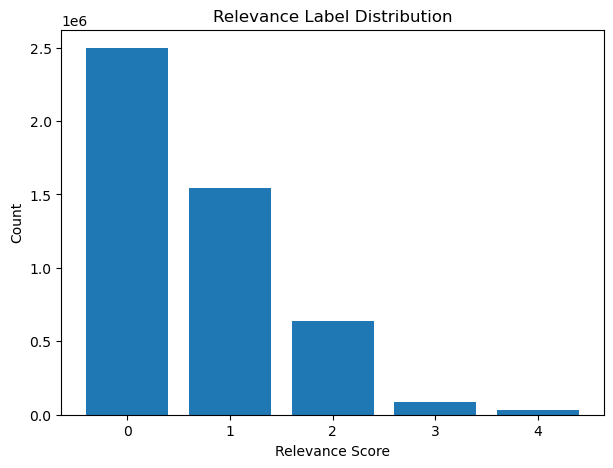

In [27]:
all_qids = np.concatenate([
    qid_train_Fold1, qid_train_Fold2, qid_train_Fold3, qid_train_Fold4, qid_train_Fold5,
    qid_test_Fold1, qid_test_Fold2, qid_test_Fold3, qid_test_Fold4, qid_test_Fold5
])

unique_queries_total = len(np.unique(all_qids))

print(f"Number of unique queries in total: {unique_queries_total}")

relevance_counts_total = Counter(np.concatenate([
    y_train_Fold1, y_train_Fold2, y_train_Fold3, y_train_Fold4, y_train_Fold5,
    y_test_Fold1, y_test_Fold2, y_test_Fold3, y_test_Fold4, y_test_Fold5
]))

plt.figure(figsize=(7, 5))
plt.bar(relevance_counts_total.keys(), relevance_counts_total.values())
plt.title("Relevance Label Distribution")
plt.xlabel("Relevance Score")
plt.ylabel("Count")
plt.show()


Question 14

In [30]:
def train_and_eval(X_train, y_train, group_train, X_test, y_test, qid_test):
    model = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        verbose=-1
    )
    model.fit(X_train, y_train, group=group_train)

    ndcg_at_3 = compute_ndcg_all(model, X_test, y_test, qid_test, k=3)
    ndcg_at_5 = compute_ndcg_all(model, X_test, y_test, qid_test, k=5)
    ndcg_at_10 = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)

    return ndcg_at_3, ndcg_at_5, ndcg_at_10

folds = [
    (X_train_Fold1, y_train_Fold1, group_train_Fold1, X_test_Fold1, y_test_Fold1, qid_test_Fold1),
    (X_train_Fold2, y_train_Fold2, group_train_Fold2, X_test_Fold2, y_test_Fold2, qid_test_Fold2),
    (X_train_Fold3, y_train_Fold3, group_train_Fold3, X_test_Fold3, y_test_Fold3, qid_test_Fold3),
    (X_train_Fold4, y_train_Fold4, group_train_Fold4, X_test_Fold4, y_test_Fold4, qid_test_Fold4),
    (X_train_Fold5, y_train_Fold5, group_train_Fold5, X_test_Fold5, y_test_Fold5, qid_test_Fold5)
]

for i, (X_train, y_train, group_train, X_test, y_test, qid_test) in enumerate(folds, start=1):
    ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_and_eval(X_train, y_train, group_train, X_test, y_test, qid_test)
    print(f"Fold {i} - nDCG@3: {ndcg_at_3:.4f}, nDCG@5: {ndcg_at_5:.4f}, nDCG@10: {ndcg_at_10:.4f}")


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 - nDCG@3: 0.4565, nDCG@5: 0.4633, nDCG@10: 0.4829


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 - nDCG@3: 0.4539, nDCG@5: 0.4573, nDCG@10: 0.4768


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 - nDCG@3: 0.4491, nDCG@5: 0.4583, nDCG@10: 0.4759


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 - nDCG@3: 0.4612, nDCG@5: 0.4664, nDCG@10: 0.4877


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 - nDCG@3: 0.4696, nDCG@5: 0.4714, nDCG@10: 0.4904


Question 15

In [35]:
def feature_importance(X_train, y_train, group_train):
    model = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        verbose=-1
    )

    model.fit(X_train, y_train, group=group_train)
    feature_importance_scores = get_feature_importance(model, importance_type='gain')
    feature_importance_df = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(len(feature_importance_scores))],
        'Importance': feature_importance_scores
    }).sort_values(by="Importance", ascending=False)
    top_5_features = feature_importance_df.head(5)

    return top_5_features

folds = [
    (X_train_Fold1, y_train_Fold1, group_train_Fold1),
    (X_train_Fold2, y_train_Fold2, group_train_Fold2),
    (X_train_Fold3, y_train_Fold3, group_train_Fold3),
    (X_train_Fold4, y_train_Fold4, group_train_Fold4),
    (X_train_Fold5, y_train_Fold5, group_train_Fold5)
]

for i, (X_train, y_train, group_train) in enumerate(folds, start=1):
    top_5_features = feature_importance(X_train, y_train, group_train)
    print(f"Top 5 Features for Fold {i}:")
    print(top_5_features.to_string(index=False))
    print("\n")


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 5 Features for Fold 1:
    Feature   Importance
Feature_133 23856.702951
  Feature_7  4248.546391
Feature_107  4135.244450
 Feature_54  4078.463226
Feature_129  3635.037024




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 5 Features for Fold 2:
    Feature   Importance
Feature_133 23578.908250
  Feature_7  5157.964912
 Feature_54  4386.669757
Feature_107  4094.012172
Feature_129  4035.070673




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 5 Features for Fold 3:
    Feature   Importance
Feature_133 23218.075441
 Feature_54  4991.303372
Feature_107  4226.807395
Feature_129  4059.752514
  Feature_7  3691.792320




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 5 Features for Fold 4:
    Feature   Importance
Feature_133 23796.899673
  Feature_7  4622.622978
 Feature_54  3883.481706
Feature_129  3356.846980
Feature_128  3207.575537




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 5 Features for Fold 5:
    Feature   Importance
Feature_133 23540.942354
  Feature_7  4794.945172
 Feature_54  4079.608554
Feature_107  3514.835752
Feature_129  3209.058444




Question 16

In [36]:
def train_removed(X_train, y_train, group_train, X_test, y_test, qid_test, remove_top_n=0, remove_least_n=0):
    base_model = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        verbose=-1
    )

    base_model.fit(X_train, y_train, group=group_train)
    
    feature_importance_scores = get_feature_importance(base_model, importance_type='gain')

    feature_importance_df = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(len(feature_importance_scores))],
        'Importance': feature_importance_scores
    }).sort_values(by="Importance", ascending=False)

    if remove_top_n > 0:
        top_features_to_remove = feature_importance_df.head(remove_top_n)['Feature'].values
    else:
        top_features_to_remove = []

    if remove_least_n > 0:
        least_features_to_remove = feature_importance_df.tail(remove_least_n)['Feature'].values
    else:
        least_features_to_remove = []

    features_to_remove = set(top_features_to_remove) | set(least_features_to_remove)
    feature_indices_to_keep = [i for i in range(len(feature_importance_scores)) if f'Feature_{i}' not in features_to_remove]

    X_train_reduced = X_train[:, feature_indices_to_keep]
    X_test_reduced = X_test[:, feature_indices_to_keep]

    model = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        verbose=-1
    )

    model.fit(X_train_reduced, y_train, group=group_train)

    ndcg_at_3 = compute_ndcg_all(model, X_test_reduced, y_test, qid_test, k=3)
    ndcg_at_5 = compute_ndcg_all(model, X_test_reduced, y_test, qid_test, k=5)
    ndcg_at_10 = compute_ndcg_all(model, X_test_reduced, y_test, qid_test, k=10)

    return ndcg_at_3, ndcg_at_5, ndcg_at_10

folds = [
    (X_train_Fold1, y_train_Fold1, group_train_Fold1, X_test_Fold1, y_test_Fold1, qid_test_Fold1),
    (X_train_Fold2, y_train_Fold2, group_train_Fold2, X_test_Fold2, y_test_Fold2, qid_test_Fold2),
    (X_train_Fold3, y_train_Fold3, group_train_Fold3, X_test_Fold3, y_test_Fold3, qid_test_Fold3),
    (X_train_Fold4, y_train_Fold4, group_train_Fold4, X_test_Fold4, y_test_Fold4, qid_test_Fold4),
    (X_train_Fold5, y_train_Fold5, group_train_Fold5, X_test_Fold5, y_test_Fold5, qid_test_Fold5)
]

print("Removed Top 20 Features")
for i, (X_train, y_train, group_train, X_test, y_test, qid_test) in enumerate(folds, start=1):
    ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_removed(X_train, y_train, group_train, X_test, y_test, qid_test, remove_top_n=20)
    print(f"Fold {i} - nDCG@3: {ndcg_at_3:.4f}, nDCG@5: {ndcg_at_5:.4f}, nDCG@10: {ndcg_at_10:.4f}")
    print("\n")

print("Removed Least 60 Features")
for i, (X_train, y_train, group_train, X_test, y_test, qid_test) in enumerate(folds, start=1):
    ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_removed(X_train, y_train, group_train, X_test, y_test, qid_test, remove_least_n=60)
    print(f"Fold {i} - nDCG@3: {ndcg_at_3:.4f}, nDCG@5: {ndcg_at_5:.4f}, nDCG@10: {ndcg_at_10:.4f}")
    print("\n")


Removed Top 20 Features


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 - nDCG@3: 0.3797, nDCG@5: 0.3850, nDCG@10: 0.4084




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 - nDCG@3: 0.3739, nDCG@5: 0.3820, nDCG@10: 0.4045




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 - nDCG@3: 0.3824, nDCG@5: 0.3900, nDCG@10: 0.4116




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 - nDCG@3: 0.3820, nDCG@5: 0.3928, nDCG@10: 0.4121




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 - nDCG@3: 0.3843, nDCG@5: 0.3922, nDCG@10: 0.4167


Removed Least 60 Features


/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 - nDCG@3: 0.4543, nDCG@5: 0.4627, nDCG@10: 0.4820




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 - nDCG@3: 0.4573, nDCG@5: 0.4603, nDCG@10: 0.4773




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 - nDCG@3: 0.4498, nDCG@5: 0.4586, nDCG@10: 0.4774




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 - nDCG@3: 0.4606, nDCG@5: 0.4673, nDCG@10: 0.4889




/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 - nDCG@3: 0.4702, nDCG@5: 0.4734, nDCG@10: 0.4908


